In [285]:
import pandas as pd
import mysql.connector
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [78]:
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='@vishal123',
    database='ecommerce'
)

cur = conn.cursor()

#  List of all unique cities where customers are located

In [168]:
query = """select distinct upper(customer_city) from customers"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns=['Cities'])
df.head(10)

,Cities
0,FRANCA
1,SAO BERNARDO DO CAMPO
2,SAO PAULO
3,MOGI DAS CRUZES
4,CAMPINAS
5,JARAGUA DO SUL
6,TIMOTEO
7,CURITIBA
8,BELO HORIZONTE
9,MONTES CLAROS


# Count the number of orders placed in 2017.

In [88]:
query = """select count(order_id) from orders where year(order_purchase_timestamp)=2017"""

cur.execute(query)

data = cur.fetchall()

print("total orders placed in 2017", data[0][0])

total orders placed in 2017 135303


# Find the total sales per category.

In [111]:
query = """select upper(products.product_category) as category,
 round(sum(payments.payment_value),2) as sales
 from products join order_items 
 on products.product_id = order_items.product_id 
 join payments
 on payments.order_id = order_items.order_id
 group by category"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Category', 'Sales'])
df

,Category,Sales
0,PERFUMERY,1013477.32
1,FURNITURE DECORATION,2860352.78
2,TELEPHONY,973764.10
3,BED TABLE BATH,3425107.34
4,AUTOMOTIVE,1704588.66
...,...,...
69,CDS MUSIC DVDS,2398.86
70,LA CUISINE,5827.06
71,FASHION CHILDREN'S CLOTHING,1571.34
72,PC GAMER,4348.86


# Calculate the percentage of orders that were paid in installments

In [127]:
query = """select (sum(case when payment_installments>=1 then 1 
     else 0 end))/count(*)*100 from payments"""

cur.execute(query)

data = cur.fetchall()
data

[(Decimal('99.9981'),)]

# Count the number of customers from each state.

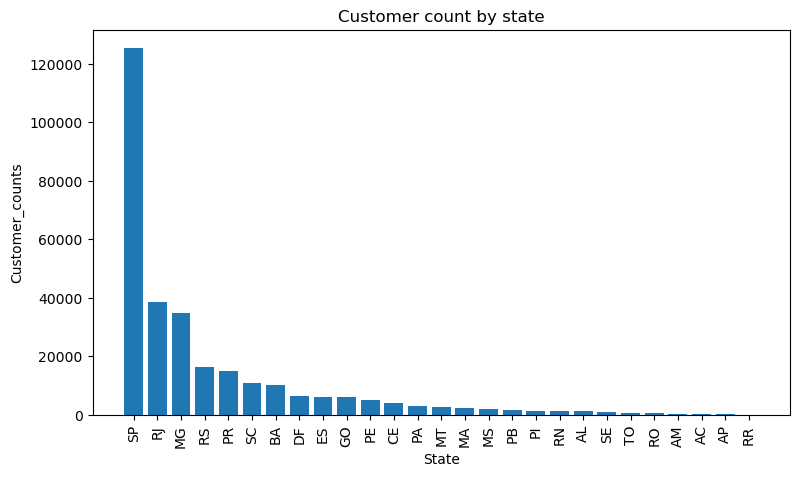

In [221]:
query = """select customer_state, count(customer_id) from customers group by customer_state """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=['State', 'Customer_count'])
df = df.sort_values(by ='Customer_count', ascending = False)
df.head()
plt.figure(figsize=(9,5))
plt.bar(df['State'],df['Customer_count'])
plt.xlabel('State')
plt.ylabel('Customer_counts')
plt.xticks(rotation =90)
plt.title('Customer count by state')
plt.show()

# Calculate the number of orders per month in 2018.

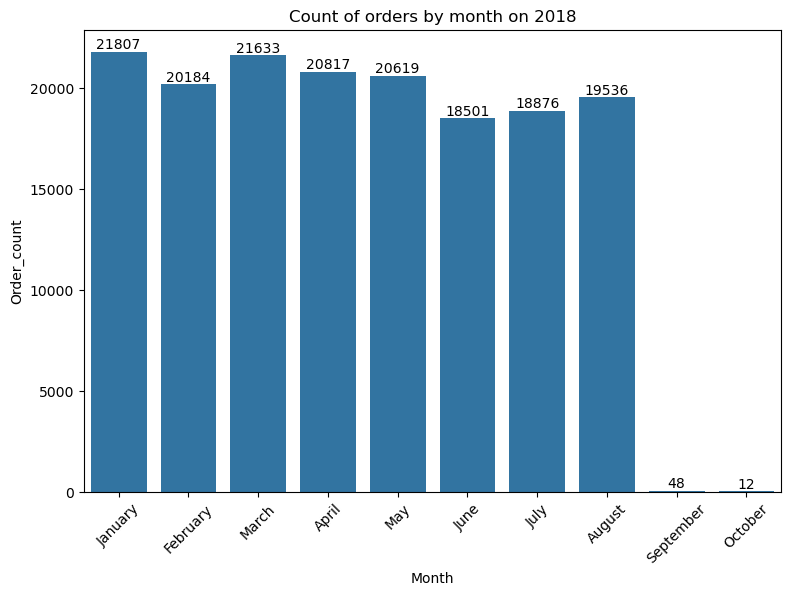

In [225]:
query = """select monthname(order_purchase_timestamp) as month, count(order_id) as order_count from orders
    where year(order_purchase_timestamp)=2018 
    group by month"""

cur.execute(query)

data = cur.fetchall()

df=pd.DataFrame(data, columns=['Month','Order_count'])
o=["January","February","March","April","May","June","July","August","September","October"]
plt.figure(figsize=(9,6))
ax=sns.barplot(x=df['Month'],y=df['Order_count'],data=df, order=o)
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title('Count of orders by month on 2018')
plt.show()

# Find the average number of products per order, grouped by customer city.

In [266]:
query = """with count_per_order as (
    select 
        orders.order_id,
        orders.customer_id, 
        count(order_items.order_id) as oc
    from orders 
    join order_items on orders.order_id = order_items.order_id
    group by orders.order_id, orders.customer_id
)
select 
    upper(customers.customer_city), 
    avg(count_per_order.oc) as avg_order
from customers 
join count_per_order on customers.customer_id = count_per_order.customer_id 
group by customers.customer_city order by avg_order"""
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns=['Customer_city','Average product per order'])
df.head(5)

,Customer_city,Average product per order
0,SAO VENDELINO,3.0000
1,CHAPADA DO NORTE,3.0000
2,GUARANTA,3.0000
3,URUSSANGA,3.0000
4,CORONEL JOAO SA,3.0000


# Calculate the percentage of total revenue contributed by each product category

In [264]:
query = """select upper(products.product_category) as category,
 round((sum(payments.payment_value)/ (select sum(payment_value) from payments))*100,2)as sales
 from products join order_items 
 on products.product_id = order_items.product_id 
 join payments
 on payments.order_id = order_items.order_id
 group by category order by sales desc"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=['Category', 'Sales %'])
df

,Category,Sales %
0,BED TABLE BATH,21.40
1,HEALTH BEAUTY,20.71
2,COMPUTER ACCESSORIES,19.81
3,FURNITURE DECORATION,17.87
4,WATCHES PRESENT,17.86
...,...,...
69,PC GAMER,0.03
70,HOUSE COMFORT 2,0.02
71,CDS MUSIC DVDS,0.01
72,FASHION CHILDREN'S CLOTHING,0.01


#  Identify the correlation between product price and the number of times a product has been purchased.

In [303]:
query = """select products.product_category, count(order_items.product_id),
        round(avg(order_items.price),2) from products join order_items
        on products.product_id = order_items.product_id 
        group by products.product_category"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=['Category', 'Order Count','Price'])
co_rel = df[['Order Count','Price']].corr()

arr1 = df['Order Count']
arr2 = df['Price']

a=np.corrcoef([arr1,arr2])
print("The Correlation is",a[0][1])

The Correlation is -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue

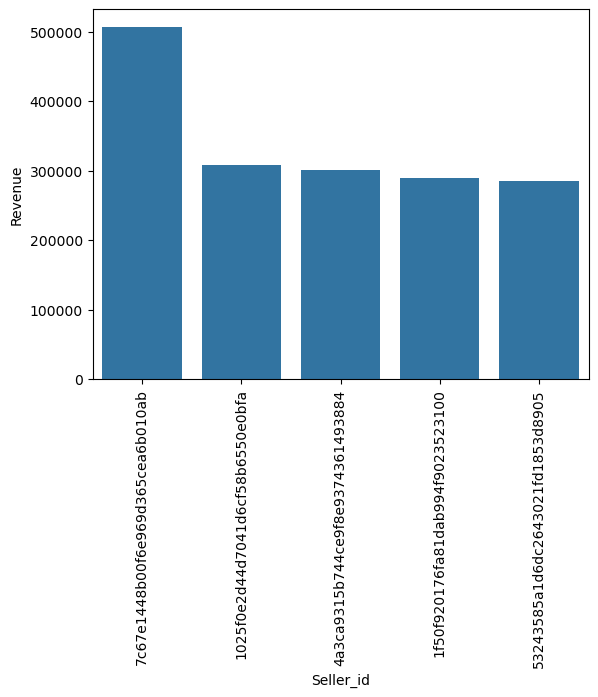

In [328]:
query = """select *, dense_rank() over(order by revenue desc) as rn from 
        (select order_items.seller_id, sum(payments.payment_value) as revenue
        from order_items join payments on order_items.order_id = payments.order_id
        group by order_items.seller_id) as a"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=['Seller_id', 'Revenue', 'Rank'])
df = df.head()
sns.barplot(x='Seller_id',y='Revenue',data=df)
plt.xticks(rotation=90)
plt.show()